# Pairs Trading Backtest Notebook

This comprehensive notebook supports both StaticFit and SlidingFit.
It automatically adapts its analysis and visualization based on the strategy specified in the configuration file.

## Key Features:

1. **Configuration-Driven**: Loads strategy and parameters from HJSON configuration files
2. **Dual Model Support**: Works with both StaticFit and SlidingFit
3. **Adaptive Visualization**: Different visualizations based on selected strategy
4. **Comprehensive Analysis**: Deep analysis of trading pairs and dis-equilibrium
5. **Interactive Configuration**: Easy parameter adjustment and re-running

## Usage:

1. **Configure Parameters**: Set CONFIG_FILE, SYMBOL_A, SYMBOL_B, and TRADING_DATE
2. **Run Analysis**: Execute cells step by step
3. **View Results**: Comprehensive visualizations and trading signals
4. **Experiment**: Modify parameters and re-run for different scenarios



# Settings

In [1]:
# Trading Parameters Configuration
# Specify your configuration file, trading symbols and date here

# Configuration file selection
CONFIG_FILE = "equity"  # Options: "equity", "crypto", or custom filename (without .cfg extension)

# Trading pair symbols
SYMBOL_A = "COIN"   # Change this to your desired symbol A
SYMBOL_B = "MSTR"   # Change this to your desired symbol B

# Date for data file selection (format: YYYYMMDD)
TRADING_DATE = "20250605"  # Change this to your desired date


# Setup and Configuration

## Code Setup

In [2]:
import sys
import os
sys.path.append('/home/oleg/develop/pairs_trading/lib')
sys.path.append('/home/coder/pairs_trading/lib')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from typing import Dict, List, Optional
from IPython.display import clear_output

# Import our modules
from pt_trading.fit_methods import StaticFit, SlidingFit, PairState
from tools.data_loader import load_market_data
from pt_trading.trading_pair import TradingPair
from pt_trading.results import BacktestResult

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

print("Setup complete!")


Setup complete!


## Load Configuration


In [3]:
# Load Configuration from Configuration Files using HJSON
import hjson
import os

def load_config_from_file(config_type) -> Optional[Dict]:
    """Load configuration from configuration files using HJSON"""
    config_file = f"../../configuration/{config_type}.cfg"
    
    try:
        with open(config_file, 'r') as f:
            # HJSON handles comments, trailing commas, and other human-friendly features
            config = hjson.load(f)
        
        # Convert relative paths to absolute paths from notebook perspective
        if 'data_directory' in config:
            data_dir = config['data_directory']
            if data_dir.startswith('./'):
                # Convert relative path to absolute path from notebook's perspective
                config['data_directory'] = os.path.abspath(f"../../{data_dir[2:]}")
        
        return config
        
    except FileNotFoundError:
        print(f"Configuration file not found: {config_file}")
        return None
    except hjson.HjsonDecodeError as e:
        print(f"HJSON parsing error in {config_file}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error loading config from {config_file}: {e}")
        return None

def instantiate_fit_method_from_config(config: Dict):
    """Dynamically instantiate strategy from config"""
    fit_method_class_name = config.get("fit_method_class", None)
    assert fit_method_class_name is not None
    try:
        # Split module and class name
        if '.' in fit_method_class_name:
            module_name, class_name = fit_method_class_name.rsplit('.', 1)
        else:
            module_name = "fit_methods"
            class_name = fit_method_class_name
        
        # Import module and get class
        module = importlib.import_module(module_name)
        fit_method_class = getattr(module, class_name)
        
        # Instantiate strategy
        return fit_method_class()
        
    except Exception as e:
        print(f"Error instantiating strategy {fit_method_class_name}: {e}")
        raise Exception(f"Error instantiating strategy {fit_method_class_name}: {e}") from e


## Print Configuration

In [4]:
print(f"Trading Parameters:")
print(f"  Configuration: {CONFIG_FILE}")
print(f"  Symbol A: {SYMBOL_A}")
print(f"  Symbol B: {SYMBOL_B}")
print(f"  Trading Date: {TRADING_DATE}")

# Load the specified configuration
print(f"\nLoading {CONFIG_FILE} configuration using HJSON...")

CONFIG = load_config_from_file(CONFIG_FILE)
assert CONFIG is not None
pt_bt_config: Dict = dict(CONFIG)

if pt_bt_config:
    print(f"✓ Successfully loaded {pt_bt_config['security_type']} configuration")
    print(f"  Data directory: {pt_bt_config['data_directory']}")
    print(f"  Database table: {pt_bt_config['db_table_name']}")
    print(f"  Exchange: {pt_bt_config['exchange_id']}")
    print(f"  Training window: {pt_bt_config['training_minutes']} minutes")
    print(f"  Open threshold: {pt_bt_config['dis-equilibrium_open_trshld']}")
    print(f"  Close threshold: {pt_bt_config['dis-equilibrium_close_trshld']}")
    
    # Instantiate strategy from config
    FIT_MODEL = instantiate_fit_method_from_config(pt_bt_config)
    print(f"  Strategy: {type(FIT_MODEL).__name__}")
    
    # Automatically construct data file name based on date and config type
    DATA_FILE = f"{TRADING_DATE}.mktdata.ohlcv.db"

    # Update CONFIG with the specific data file and instruments
    pt_bt_config["datafiles"] = [DATA_FILE]
    pt_bt_config["instruments"] = [SYMBOL_A, SYMBOL_B]
    
    print(f"\nData Configuration:")
    print(f"  Data File: {DATA_FILE}")
    print(f"  Security Type: {pt_bt_config['security_type']}")
    
    # Verify data file exists
    data_file_path = f"{pt_bt_config['data_directory']}/{DATA_FILE}"
    if os.path.exists(data_file_path):
        print(f"  ✓ Data file found: {data_file_path}")
    else:
        print(f"  ⚠ Data file not found: {data_file_path}")
        print(f"    Please check if the date and file exist in the data directory")
        
        # List available files in the data directory
        try:
            data_dir = pt_bt_config['data_directory']
            if os.path.exists(data_dir):
                available_files = [f for f in os.listdir(data_dir) if f.endswith('.db')]
                print(f"    Available files in {data_dir}:")
                for file in sorted(available_files)[:5]:  # Show first 5 files
                    print(f"      - {file}")
                if len(available_files) > 5:
                    print(f"      ... and {len(available_files)-5} more files")
        except Exception as e:
            print(f"    Could not list files in data directory: {e}")
else:
    print("⚠ Failed to load configuration. Please check the configuration file.")


Trading Parameters:
  Configuration: equity
  Symbol A: COIN
  Symbol B: MSTR
  Trading Date: 20250605

Loading equity configuration using HJSON...
✓ Successfully loaded EQUITY configuration
  Data directory: /home/oleg/develop/pairs_trading/data/equity
  Database table: md_1min_bars
  Exchange: ALPACA
  Training window: 120 minutes
  Open threshold: 2
  Close threshold: 1
  Strategy: SlidingFit

Data Configuration:
  Data File: 20250605.mktdata.ohlcv.db
  Security Type: EQUITY
  ✓ Data file found: /home/oleg/develop/pairs_trading/data/equity/20250605.mktdata.ohlcv.db


## Load and Prepare Market Data


In [5]:
# Load market data
datafile_path = f"{pt_bt_config['data_directory']}/{DATA_FILE}"
print(f"Loading data from: {datafile_path}")

market_data_df = load_market_data(datafile_path, config=pt_bt_config)

print(f"Loaded {len(market_data_df)} rows of market data")
print(f"Symbols in data: {market_data_df['symbol'].unique()}")
print(f"Time range: {market_data_df['tstamp'].min()} to {market_data_df['tstamp'].max()}")

# Create trading pair
pair = TradingPair(
    market_data=market_data_df,
    symbol_a=SYMBOL_A,
    symbol_b=SYMBOL_B,
    price_column=pt_bt_config["price_column"]
)

print(f"\nCreated trading pair: {pair}")
print(f"Market data shape: {pair.market_data_.shape}")
print(f"Column names: {pair.colnames()}")

# Display sample data
print(f"\nSample data:")
display(pair.market_data_.head())


Loading data from: /home/oleg/develop/pairs_trading/data/equity/20250605.mktdata.ohlcv.db
Loaded 782 rows of market data
Symbols in data: ['COIN' 'MSTR']
Time range: 2025-06-05 13:30:00 to 2025-06-05 20:00:00

Created trading pair: COIN & MSTR
Market data shape: (391, 3)
Column names: ['close_COIN', 'close_MSTR']

Sample data:


tstamp  close_COIN  close_MSTR
0 2025-06-05 13:30:00     263.380    384.7700
1 2025-06-05 13:31:00     265.385    382.7806
2 2025-06-05 13:32:00     263.735    379.8300
3 2025-06-05 13:33:00     264.250    380.0400
4 2025-06-05 13:34:00     262.230    379.6400

In [6]:
# Fixed draw_symbol_trades function
def draw_symbol_trades_fixed(fig, symbol_name, color, symbol_data, colname):
    # Add Symbol price data to row 4 (subplot 4)
    fig.add_trace(
        go.Scatter(
            x=symbol_data['tstamp'],
            y=symbol_data[colname],
            name=f'{symbol_name} Price',
            line=dict(color=color, width=2),
            opacity=0.8
        ),
        row=4, col=1
    )
    
    # Add trading signals for Symbol if available
    if pair_trades is not None and len(pair_trades) > 0:
        # Filter trades for this symbol
        symbol_trades = pair_trades[pair_trades['symbol'] == symbol_name].copy()
        
        if len(symbol_trades) > 0:
            # Separate trades by action and status - filter the trades, not the price data
            buy_open_trades = symbol_trades[(symbol_trades['action'].str.contains('BUY', na=False)) & 
                                            (symbol_trades['status'] == 'OPEN')]
            buy_close_trades = symbol_trades[(symbol_trades['action'].str.contains('BUY', na=False)) & 
                                            (symbol_trades['status'] == 'CLOSE')]
            sell_open_trades = symbol_trades[(symbol_trades['action'].str.contains('SELL', na=False)) & 
                                            (symbol_trades['status'] == 'OPEN')]
            sell_close_trades = symbol_trades[(symbol_trades['action'].str.contains('SELL', na=False)) & 
                                            (symbol_trades['status'] == 'CLOSE')]
            
            # Add BUY OPEN signals
            if len(buy_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_open_trades['time'],
                        y=buy_open_trades['price'],
                        mode='markers',
                        name=f'{symbol_name} BUY OPEN',
                        marker=dict(color='red', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add BUY CLOSE signals
            if len(buy_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_close_trades['time'],
                        y=buy_close_trades['price'],
                        mode='markers',
                        name=f'{symbol_name} BUY CLOSE',
                        marker=dict(color='red', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add SELL OPEN signals
            if len(sell_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_open_trades['time'],
                        y=sell_open_trades['price'],
                        mode='markers',
                        name=f'{symbol_name} SELL OPEN',
                        marker=dict(color='blue', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add SELL CLOSE signals
            if len(sell_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_close_trades['time'],
                        y=sell_close_trades['price'],
                        mode='markers',
                        name=f'{symbol_name} SELL CLOSE',
                        marker=dict(color='blue', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=4, col=1
                )

print("Fixed draw_symbol_trades function created successfully!")
print("This function correctly filters trades data rather than trying to filter price data with trade conditions.")


Fixed draw_symbol_trades function created successfully!
This function correctly filters trades data rather than trying to filter price data with trade conditions.


## Fit Method Functions

In [7]:
def run_static_fit(config: Dict, pair: TradingPair, bt_result: BacktestResult) -> bool:
    is_cointegrated = False
    print("\n=== STATIC FIT ANALYSIS ===")
    
    # For StaticFit, we do traditional training/testing split
    training_minutes = pt_bt_config["training_minutes"]
    pair.get_datasets(training_minutes=training_minutes)
    
    print(f"Training data: {len(pair.training_df_)} rows")
    print(f"Testing data: {len(pair.testing_df_)} rows")
    print(f"Training period: {pair.training_df_['tstamp'].iloc[0]} to {pair.training_df_['tstamp'].iloc[-1]}")
    print(f"Testing period: {pair.testing_df_['tstamp'].iloc[0]} to {pair.testing_df_['tstamp'].iloc[-1]}")
    
    # Train and test cointegration
    is_cointegrated = pair.train_pair()
    print(f"Pair cointegration status: {is_cointegrated}")
    
    if is_cointegrated:
        print(f"VECM Beta coefficients: {pair.vecm_fit_.beta.flatten()}")
        print(f"Training dis-equilibrium mean: {pair.training_mu_:.6f}")
        print(f"Training dis-equilibrium std: {pair.training_std_:.6f}")
        
        # Generate predictions and run strategy
        pair.predict()
        pair_trades = FIT_MODEL.run_pair(config=pt_bt_config, pair=pair, bt_result=bt_result)
        
        if pair_trades is not None and len(pair_trades) > 0:
            print(f"Generated {len(pair_trades)} trading signals")
        else:
            print("No trading signals generated")
    else:
        print("Pair is not cointegrated - cannot proceed with strategy")

    return is_cointegrated


## Print Strategy Specifics


In [8]:
# Determine analysis approach based on strategy type
FIT_METHOD_TYPE = type(FIT_MODEL).__name__
print(f"Analysis for {FIT_METHOD_TYPE}...")

if FIT_METHOD_TYPE == "StaticFit":
    print("\n=== STATIC FIT FIT_MODEL ANALYSIS ===")
    print("This strategy:")
    print("  - Fits cointegration model once using training data")
    print("  - Uses fixed parameters for entire trading period")
    print("  - Generates trading signals based on static thresholds")
    
elif FIT_METHOD_TYPE == "SlidingFit":
    print("\n=== SLIDING FIT FIT_MODEL ANALYSIS ===")
    print("This strategy:")
    print("  - Re-fits cointegration model using sliding window")
    print("  - Adapts to changing market conditions")
    print("  - Dynamic parameter updates every minute")
    
    # Calculate maximum possible iterations for sliding window
    training_minutes = pt_bt_config["training_minutes"]
    max_iterations = len(pair.market_data_) - training_minutes
    print(f"\nSliding window analysis parameters:")
    print(f"  Training window size: {training_minutes} minutes")
    print(f"  Maximum iterations: {max_iterations}")
    print(f"  Total analysis time: ~{max_iterations} minutes")

print(f"\nStrategy Configuration:")
print(f"  Open threshold: {pt_bt_config['dis-equilibrium_open_trshld']}")
print(f"  Close threshold: {pt_bt_config['dis-equilibrium_close_trshld']}")
print(f"  Training minutes: {pt_bt_config['training_minutes']}")
print(f"  Funding per pair: ${pt_bt_config['funding_per_pair']}")


Analysis for SlidingFit...

=== SLIDING FIT FIT_MODEL ANALYSIS ===
This strategy:
  - Re-fits cointegration model using sliding window
  - Adapts to changing market conditions
  - Dynamic parameter updates every minute

Sliding window analysis parameters:
  Training window size: 120 minutes
  Maximum iterations: 271
  Total analysis time: ~271 minutes

Strategy Configuration:
  Open threshold: 2
  Close threshold: 1
  Training minutes: 120
  Funding per pair: $2000


## Visualize Raw Price Data


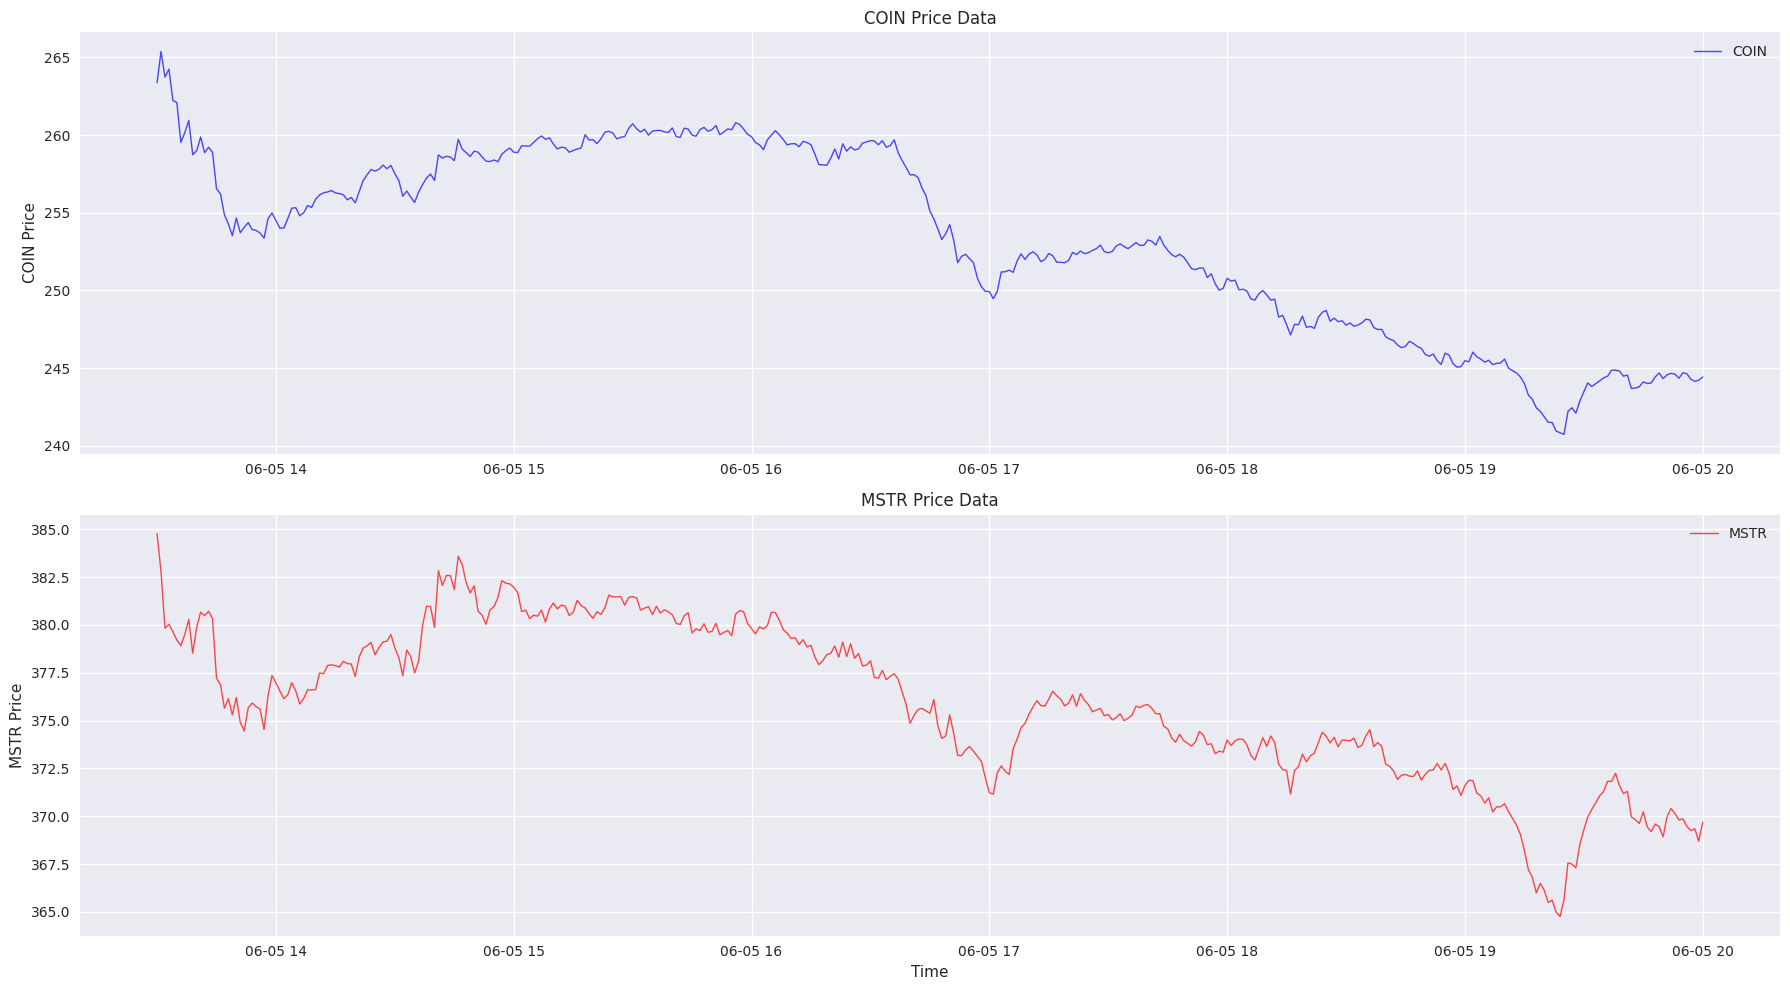

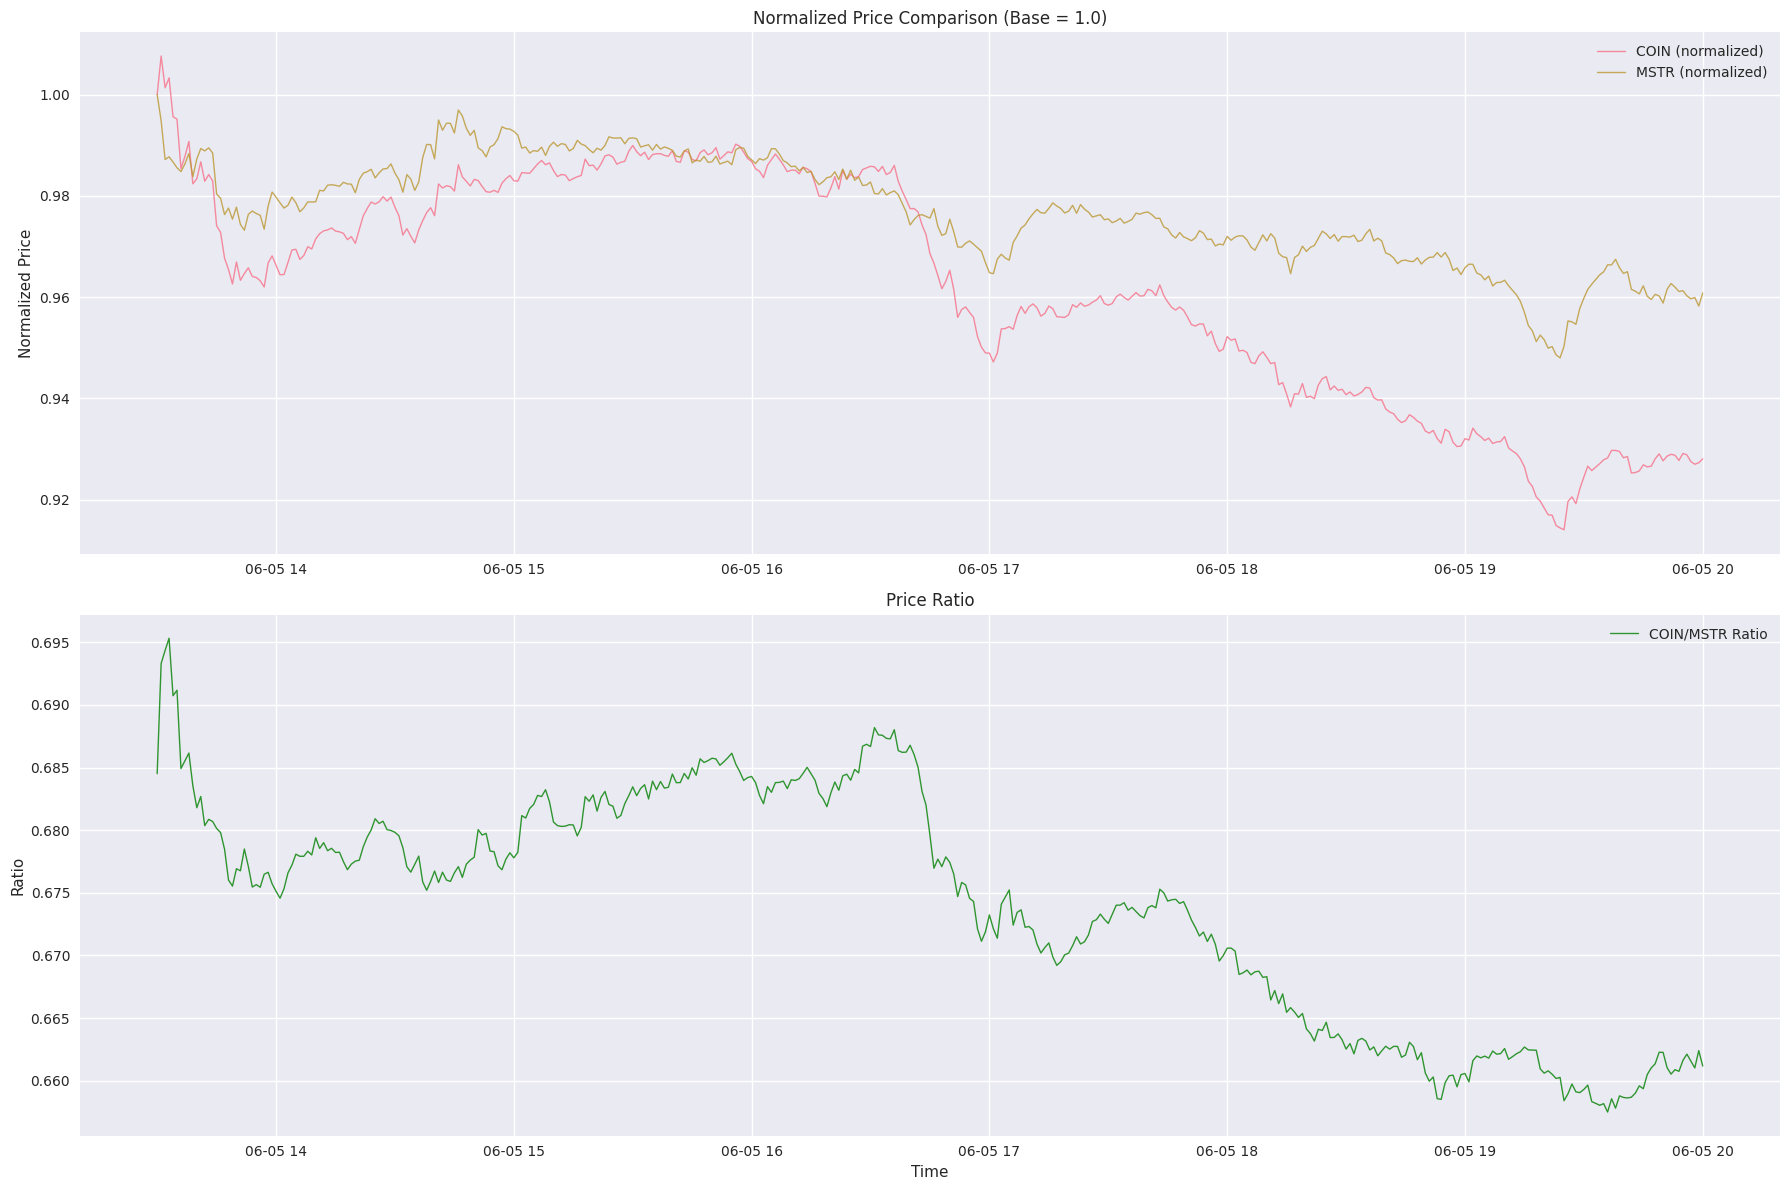


Price Statistics:
  COIN: Mean=$253.37, Std=$5.92
  MSTR: Mean=$375.88, Std=$4.10
  Price Ratio: Mean=0.67, Std=0.01
  Correlation: 0.9498


In [9]:
# Plot raw price data

# Get column names for the trading pair
colname_a, colname_b = pair.colnames()
price_data = pair.market_data_.copy()

# # 1. Price data - separate plots for each symbol
# colname_a, colname_b = pair.colnames()
# price_data = pair.market_data_.copy()

# Create separate subplots for better visibility
fig_price, price_axes = plt.subplots(2, 1, figsize=(18, 10))

# Plot SYMBOL_A
price_axes[0].plot(price_data['tstamp'], price_data[colname_a], alpha=0.7, 
                    label=f'{SYMBOL_A}', linewidth=1, color='blue')
price_axes[0].set_title(f'{SYMBOL_A} Price Data')
price_axes[0].set_ylabel(f'{SYMBOL_A} Price')
price_axes[0].legend()
price_axes[0].grid(True)

# Plot SYMBOL_B
price_axes[1].plot(price_data['tstamp'], price_data[colname_b], alpha=0.7, 
                    label=f'{SYMBOL_B}', linewidth=1, color='red')
price_axes[1].set_title(f'{SYMBOL_B} Price Data')
price_axes[1].set_ylabel(f'{SYMBOL_B} Price')
price_axes[1].set_xlabel('Time')
price_axes[1].legend()
price_axes[1].grid(True)

plt.tight_layout()
plt.show()
    

# Plot individual prices
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Normalized prices for comparison
norm_a = price_data[colname_a] / price_data[colname_a].iloc[0]
norm_b = price_data[colname_b] / price_data[colname_b].iloc[0]

axes[0].plot(price_data['tstamp'], norm_a, label=f'{SYMBOL_A} (normalized)', alpha=0.8, linewidth=1)
axes[0].plot(price_data['tstamp'], norm_b, label=f'{SYMBOL_B} (normalized)', alpha=0.8, linewidth=1)
axes[0].set_title('Normalized Price Comparison (Base = 1.0)')
axes[0].set_ylabel('Normalized Price')
axes[0].legend()
axes[0].grid(True)

# Price ratio
price_ratio = price_data[colname_a] / price_data[colname_b]
axes[1].plot(price_data['tstamp'], price_ratio, label=f'{SYMBOL_A}/{SYMBOL_B} Ratio', color='green', alpha=0.8, linewidth=1)
axes[1].set_title('Price Ratio')
axes[1].set_ylabel('Ratio')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print basic statistics
print(f"\nPrice Statistics:")
print(f"  {SYMBOL_A}: Mean=${price_data[colname_a].mean():.2f}, Std=${price_data[colname_a].std():.2f}")
print(f"  {SYMBOL_B}: Mean=${price_data[colname_b].mean():.2f}, Std=${price_data[colname_b].std():.2f}")
print(f"  Price Ratio: Mean={price_ratio.mean():.2f}, Std={price_ratio.std():.2f}")
print(f"  Correlation: {price_data[colname_a].corr(price_data[colname_b]):.4f}")


# Run

## Analysis

In [10]:
# Initialize strategy state and run analysis
print(f"Running {FIT_METHOD_TYPE} analysis...")

# Initialize result tracking
bt_result = BacktestResult(config=pt_bt_config)
pair_trades = None

# Run strategy-specific analysis
if FIT_METHOD_TYPE == "StaticFit":
    is_cointegrated = run_static_fit(config=pt_bt_config, pair=pair, bt_result=bt_result)
elif FIT_METHOD_TYPE == "SlidingFit":
    print("\n=== SLIDING FIT ANALYSIS ===")
    
    # Initialize tracking variables for sliding window analysis
    training_minutes = pt_bt_config["training_minutes"]
    max_iterations = len(pair.market_data_) - training_minutes
    
    # Limit iterations for demonstration (change this for full run)
    max_demo_iterations = min(200, max_iterations)
    print(f"Processing first {max_demo_iterations} iterations for demonstration...")
    
    # Initialize pair state for sliding fit method
    pair.user_data_['state'] = PairState.INITIAL
    pair.user_data_["trades"] = pd.DataFrame(columns=pd.Index(FIT_MODEL.TRADES_COLUMNS, dtype=str))
    pair.user_data_["is_cointegrated"] = False
    
    # Run the sliding fit method
    # ==========================================================================
    pair_trades = FIT_MODEL.run_pair(config=pt_bt_config, pair=pair, bt_result=bt_result)
    # ==========================================================================
    
    if pair_trades is not None and len(pair_trades) > 0:
        print(f"Generated {len(pair_trades)} trading signals")
    else:
        print("No trading signals generated")

print("\nStrategy execution completed!")

# Print comprehensive backtest results
print("\n" + "="*80)
print("BACKTEST RESULTS")
print("="*80)

assert pair.predicted_df_ is not None

if pair_trades is not None and len(pair_trades) > 0:
    # Print detailed results using BacktestResult methods
    bt_result.print_single_day_results()
    
    # Print trading signal details
    print(f"\nDetailed Trading Signals:")
    print(f"{'Time':<20} {'Action':<15} {'Symbol':<10} {'Price':<12} {'Scaled Dis-eq':<15}")
    print("-" * 80)
    
    for _, trade in pair_trades.head(10).iterrows():  # Show first 10 trades
        time_str = str(trade['time'])[:19] 
        action_str = str(trade['action'])[:14]
        symbol_str = str(trade['symbol'])[:9]
        price_str = f"${trade['price']:.2f}"
        diseq_str = f"{trade.get('scaled_disequilibrium', 'N/A'):.3f}" if 'scaled_disequilibrium' in trade  else 'N/A'
        
        print(f"{time_str:<20} {action_str:<15} {symbol_str:<10} {price_str:<12} {diseq_str:<15}")
    
    if len(pair_trades) > 10:
        print(f"... and {len(pair_trades)-10} more trading signals")
    
    # Print outstanding positions
    bt_result.print_outstanding_positions()
    
    # Print grand totals
    bt_result.print_grand_totals()
    
else:
    print(f"\nNo trading signals generated")
    print(f"Backtest completed with no trades")
    
    # Still print any outstanding information
    print(f"\nConfiguration Summary:")
    print(f"  Pair: {SYMBOL_A} & {SYMBOL_B}")
    print(f"  Strategy: {FIT_METHOD_TYPE}")
    print(f"  Open threshold: {pt_bt_config['dis-equilibrium_open_trshld']}")
    print(f"  Close threshold: {pt_bt_config['dis-equilibrium_close_trshld']}")
    print(f"  Training window: {pt_bt_config['training_minutes']} minutes")
    
    if FIT_METHOD_TYPE == "StaticFit":
        if 'is_cointegrated' in locals() and is_cointegrated:
            print(f"  Cointegration: ✓ Confirmed")
            if hasattr(pair, 'predicted_df_') and len(pair.predicted_df_) > 0:
                scaled_diseq = pair.predicted_df_['scaled_disequilibrium']
                max_abs_diseq = scaled_diseq.abs().max()
                print(f"  Max absolute scaled dis-equilibrium: {max_abs_diseq:.3f}")
                if max_abs_diseq < pt_bt_config['dis-equilibrium_open_trshld']:
                    print(f"  Note: Max dis-equilibrium ({max_abs_diseq:.3f}) never reached open threshold ({pt_bt_config['dis-equilibrium_open_trshld']})")
        else:
            print(f"  Cointegration: ✗ Not detected")
    elif FIT_METHOD_TYPE == "SlidingFit":
        pass # TODO: Implement sliding fit cointegration check
print("\n" + "="*80)


Running SlidingFit analysis...

=== SLIDING FIT ANALYSIS ===
Processing first 200 iterations for demonstration...
***COIN & MSTR*** STARTING....
********************************************************************************
Pair COIN & MSTR (0) IS COINTEGRATED
********************************************************************************
COIN & MSTR:  272 Not enough training data. Completing the job.
OPEN_TRADES: 2025-06-05 15:40:00 open_scaled_disequilibrium=np.float64(2.1021479687626523)
OPEN TRADES:
                 time action symbol    price  disequilibrium  \
0 2025-06-05 15:40:00   SELL   COIN  260.465        1.991597   
1 2025-06-05 15:40:00    BUY   MSTR  380.530        1.991597   

   scaled_disequilibrium         pair status  
0               2.102148  COIN & MSTR   OPEN  
1               2.102148  COIN & MSTR   OPEN  
CLOSE TRADES:
                 time action symbol     price  disequilibrium  \
0 2025-06-05 16:02:00    BUY   COIN  259.3853        0.208324   
1 2025-06-

## Visualization


=== SLIDING FIT FIT_MODEL VISUALIZATION ===
Note: Sliding strategy visualization requires detailed tracking data
For full sliding window visualization, run the complete sliding analysis
Using consistent timeline with 391 timestamps
Timeline range: 2025-06-05 13:30:00 to 2025-06-05 20:00:00


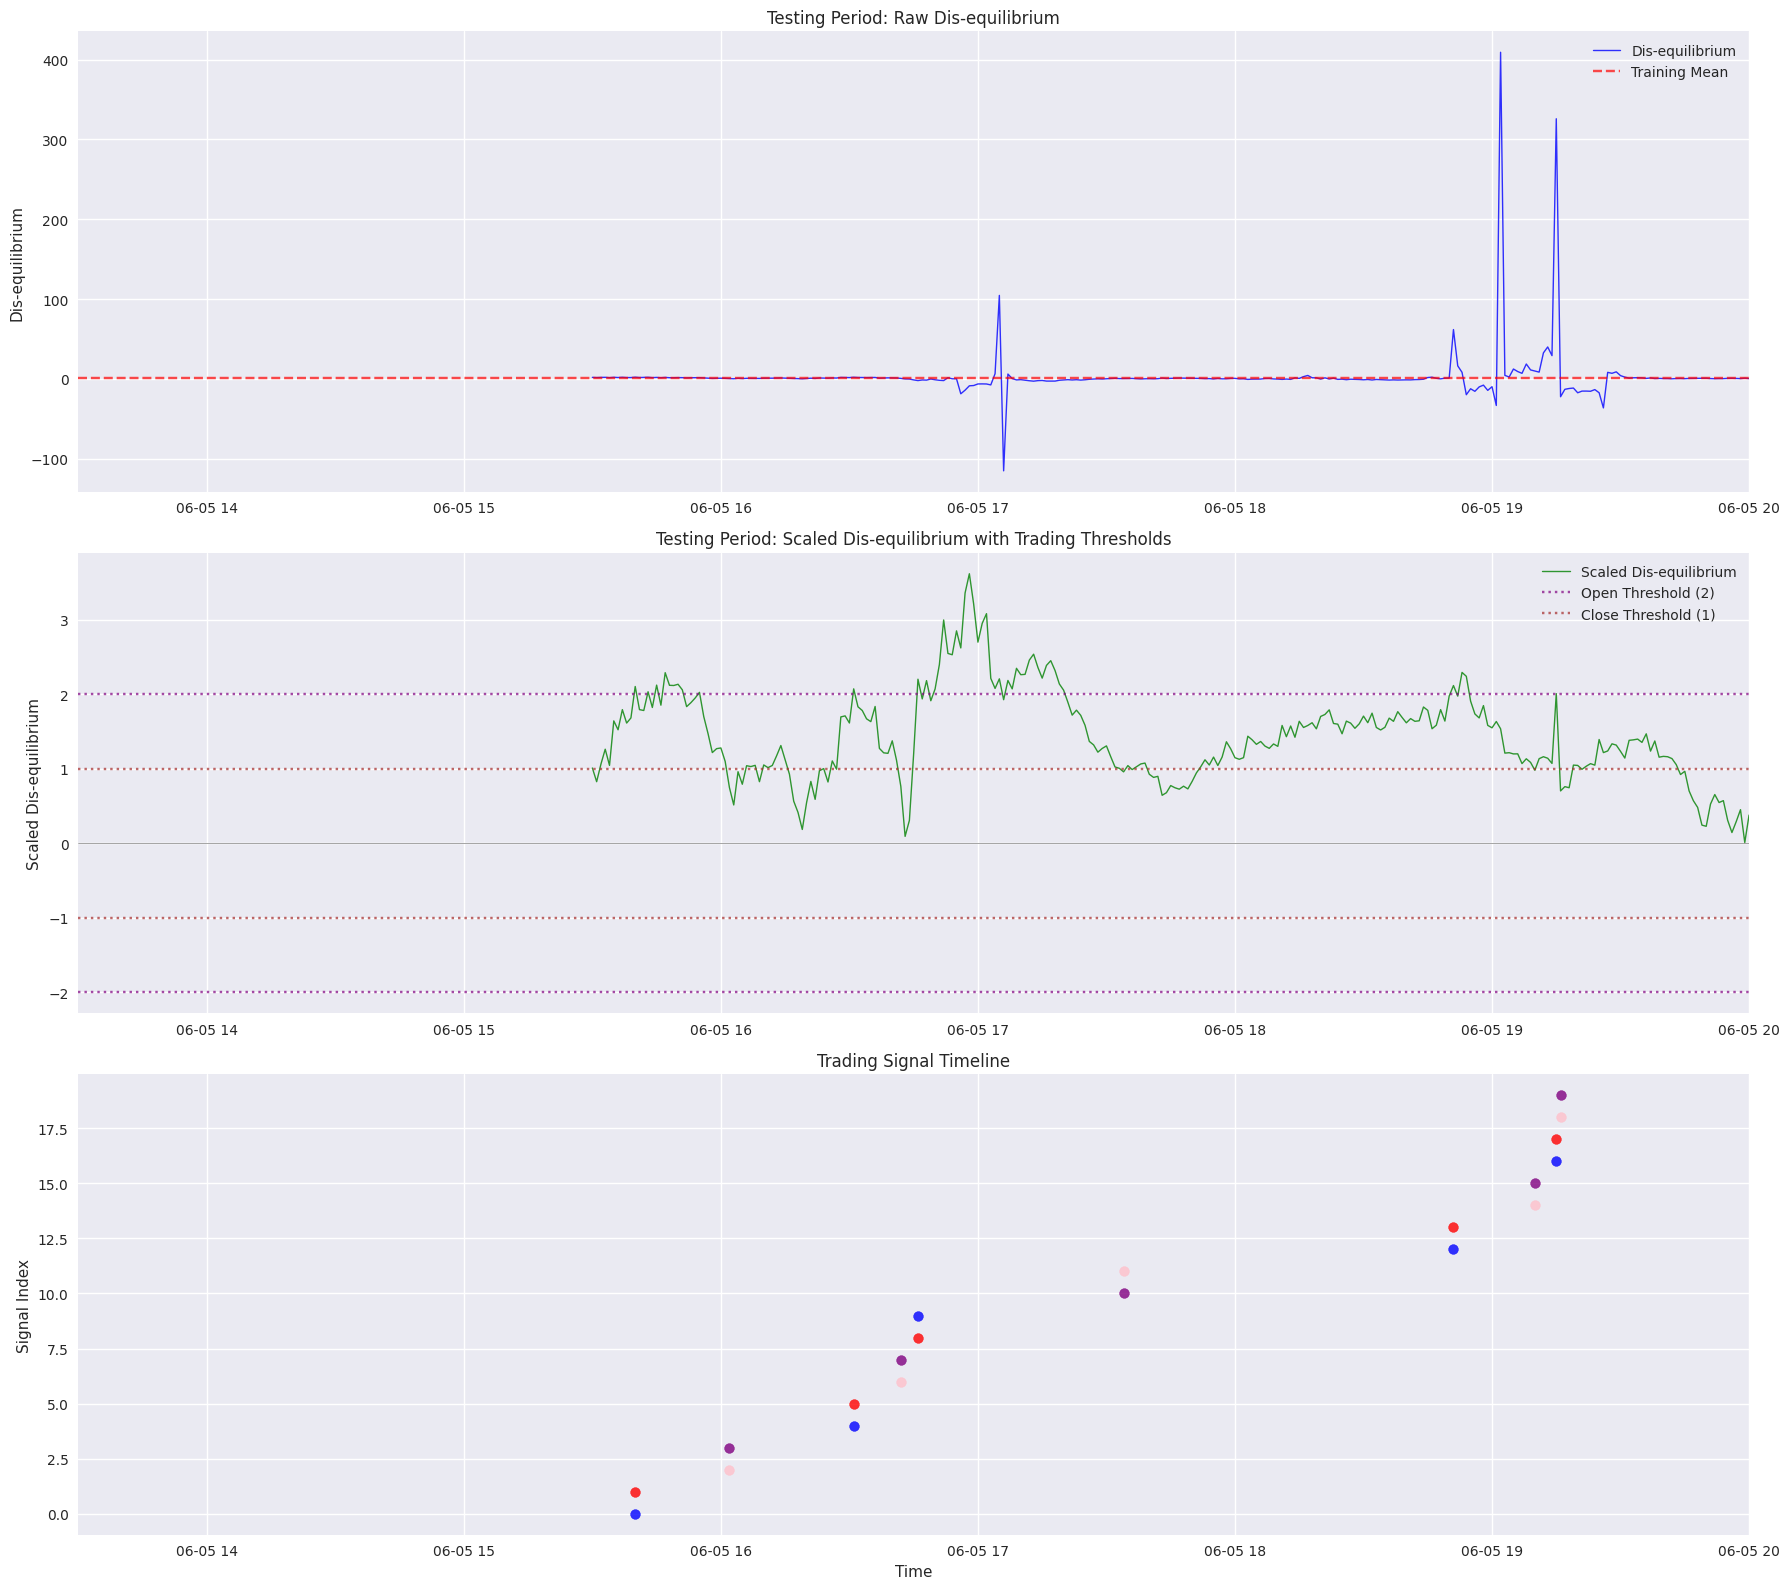

In [11]:
# Strategy-specific visualization
from matplotlib.pyplot import pink


assert pt_bt_config is not None
assert pair.predicted_df_ is not None

if FIT_METHOD_TYPE == "StaticFit" and hasattr(pair, 'predicted_df_'):
    print("=== STATIC FIT FIT_MODEL VISUALIZATION ===")
    
    fig, axes = plt.subplots(4, 1, figsize=(18, 16))
    
    # 1. Actual vs Predicted Prices
    colname_a, colname_b = pair.colnames()
    
    axes[0].plot(pair.predicted_df_['tstamp'], pair.predicted_df_[colname_a],
                 label=f'{SYMBOL_A} Actual', alpha=0.8, linewidth=1)
    axes[0].plot(pair.predicted_df_['tstamp'], pair.predicted_df_[f'{colname_a}_pred'],
                 label=f'{SYMBOL_A} Predicted', alpha=0.8, linestyle='--', linewidth=1)
    axes[0].plot(pair.predicted_df_['tstamp'], pair.predicted_df_[colname_b],
                 label=f'{SYMBOL_B} Actual', alpha=0.8, linewidth=1)
    axes[0].plot(pair.predicted_df_['tstamp'], pair.predicted_df_[f'{colname_b}_pred'],
                 label=f'{SYMBOL_B} Predicted', alpha=0.8, linestyle='--', linewidth=1)
    axes[0].set_title('Actual vs Predicted Prices')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)
    
    # 2. Raw dis-equilibrium
    axes[1].plot(pair.predicted_df_['tstamp'], pair.predicted_df_['disequilibrium'],
                 color='blue', alpha=0.8, label='Dis-equilibrium', linewidth=1)
    axes[1].axhline(y=pair.training_mu_, color='red', linestyle='--', alpha=0.7, label='Training Mean')
    axes[1].set_title('Testing Period: Raw Dis-equilibrium')
    axes[1].set_ylabel('Dis-equilibrium')
    axes[1].legend()
    axes[1].grid(True)
    
    # 3. Scaled dis-equilibrium with thresholds
    axes[2].plot(pair.predicted_df_['tstamp'], pair.predicted_df_['scaled_disequilibrium'],
                 color='green', alpha=0.8, label='Scaled Dis-equilibrium', linewidth=1)
    axes[2].axhline(y=pt_bt_config['dis-equilibrium_open_trshld'], color='purple',
                    linestyle=':', alpha=0.7, label=f"Open Threshold ({pt_bt_config['dis-equilibrium_open_trshld']})")
    axes[2].axhline(y=-pt_bt_config['dis-equilibrium_open_trshld'], color='purple',
                    linestyle=':', alpha=0.7)
    axes[2].axhline(y=pt_bt_config['dis-equilibrium_close_trshld'], color='brown',
                    linestyle=':', alpha=0.7, label=f"Close Threshold ({pt_bt_config['dis-equilibrium_close_trshld']})")
    axes[2].axhline(y=-pt_bt_config['dis-equilibrium_close_trshld'], color='brown',
                    linestyle=':', alpha=0.7)
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
    axes[2].set_title('Testing Period: Scaled Dis-equilibrium with Trading Thresholds')
    axes[2].set_ylabel('Scaled Dis-equilibrium')
    axes[2].legend()
    axes[2].grid(True)
    
    # 4. Trading signals overlay
    if pair_trades is not None and len(pair_trades) > 0:
        # Create a copy of the scaled dis-equilibrium plot
        axes[3].plot(pair.predicted_df_['tstamp'], pair.predicted_df_['scaled_disequilibrium'],
                     color='green', alpha=0.8, label='Scaled Dis-equilibrium', linewidth=1)
        axes[3].axhline(y=pt_bt_config['dis-equilibrium_open_trshld'], color='purple',
                        linestyle=':', alpha=0.7, label=f"Open Threshold")
        axes[3].axhline(y=-pt_bt_config['dis-equilibrium_open_trshld'], color='purple',
                        linestyle=':', alpha=0.7)
        
        # Add trading signals
        for idx, (_, trade) in enumerate(pair_trades.iterrows()):
            color = 'red' if 'BUY' in trade['action'] else 'blue'
            marker = '^' if 'BUY' in trade['action'] else 'v'
            axes[3].scatter(trade['time'], trade['scaled_disequilibrium'],
                           color=color, marker=marker, s=100, alpha=0.8,
                           label=f"{trade['action']} {trade['symbol']}" if idx < 2 else "")
        
        axes[3].set_title('Trading Signals on Scaled Dis-equilibrium')
    else:
        axes[3].text(0.5, 0.5, 'No Trading Signals Generated', 
                     transform=axes[3].transAxes, ha='center', va='center', fontsize=16)
        axes[3].set_title('Trading Signals (None Generated)')
    
    axes[3].set_ylabel('Scaled Dis-equilibrium')
    axes[3].set_xlabel('Time')
    axes[3].legend()
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

elif FIT_METHOD_TYPE == "SlidingFit":
    print("=== SLIDING FIT FIT_MODEL VISUALIZATION ===")
    print("Note: Sliding strategy visualization requires detailed tracking data")
    print("For full sliding window visualization, run the complete sliding analysis")
    
    # Create consistent timeline - superset of timestamps from both dataframes
    market_timestamps = set(pair.market_data_['tstamp'])
    predicted_timestamps = set(pair.predicted_df_['tstamp'])
    
    # Create superset of all timestamps
    all_timestamps = sorted(market_timestamps.union(predicted_timestamps))
    
    # Create a unified timeline dataframe for consistent plotting
    timeline_df = pd.DataFrame({'tstamp': all_timestamps})
    
    # Merge with predicted data to get dis-equilibrium values
    timeline_df = timeline_df.merge(pair.predicted_df_[['tstamp', 'disequilibrium', 'scaled_disequilibrium']], 
                                   on='tstamp', how='left')
    
    print(f"Using consistent timeline with {len(timeline_df)} timestamps")
    print(f"Timeline range: {timeline_df['tstamp'].min()} to {timeline_df['tstamp'].max()}")
    
    fig, axes = plt.subplots(3, 1, figsize=(18, 16))
    
    # 1. Raw dis-equilibrium - using consistent timeline
    axes[0].plot(timeline_df['tstamp'], timeline_df['disequilibrium'],
                 color='blue', alpha=0.8, label='Dis-equilibrium', linewidth=1)
    axes[0].axhline(y=pair.training_mu_, color='red', linestyle='--', alpha=0.7, label='Training Mean')
    axes[0].set_title('Testing Period: Raw Dis-equilibrium')
    axes[0].set_ylabel('Dis-equilibrium')
    axes[0].set_xlim(timeline_df['tstamp'].min(), timeline_df['tstamp'].max())
    axes[0].legend()
    axes[0].grid(True)
    
    # 2. Scaled dis-equilibrium with thresholds - using consistent timeline
    axes[1].plot(timeline_df['tstamp'], timeline_df['scaled_disequilibrium'],
                 color='green', alpha=0.8, label='Scaled Dis-equilibrium', linewidth=1)
    axes[1].axhline(y=pt_bt_config['dis-equilibrium_open_trshld'], color='purple',
                    linestyle=':', alpha=0.7, label=f"Open Threshold ({pt_bt_config['dis-equilibrium_open_trshld']})")
    axes[1].axhline(y=-pt_bt_config['dis-equilibrium_open_trshld'], color='purple',
                    linestyle=':', alpha=0.7)
    axes[1].axhline(y=pt_bt_config['dis-equilibrium_close_trshld'], color='brown',
                    linestyle=':', alpha=0.7, label=f"Close Threshold ({pt_bt_config['dis-equilibrium_close_trshld']})")
    axes[1].axhline(y=-pt_bt_config['dis-equilibrium_close_trshld'], color='brown',
                    linestyle=':', alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
    axes[1].set_title('Testing Period: Scaled Dis-equilibrium with Trading Thresholds')
    axes[1].set_ylabel('Scaled Dis-equilibrium')
    axes[1].set_xlim(timeline_df['tstamp'].min(), timeline_df['tstamp'].max())
    axes[1].legend()
    axes[1].grid(True)

    # 3. Trading signals if available - using consistent timeline
    if pair_trades is not None and len(pair_trades) > 0:
        # Show trading signals over time
        trade_times = pair_trades['time'].values
        trade_actions = pair_trades['action'].values
        position_statuses = pair_trades['status'].values
        
        for i, (time, action, status) in enumerate(zip(trade_times, trade_actions, position_statuses)):
            if action == "BUY":
                if status == "OPEN":
                    color='red'
                else:
                    color='pink'
            else:
                if status == "OPEN":
                    color='blue'
                else:
                    color='purple'
            axes[2].scatter(time, i, color=color, alpha=0.8, s=50)
        
        axes[2].set_title('Trading Signal Timeline')
        axes[2].set_ylabel('Signal Index')
    else:
        axes[2].text(0.5, 0.5, 'No Trading Signals Generated', 
                     transform=axes[2].transAxes, ha='center', va='center', fontsize=16)
        axes[2].set_title('Trading Signals (None Generated)')
    
    # Set consistent x-axis limits for all charts
    axes[2].set_xlim(timeline_df['tstamp'].min(), timeline_df['tstamp'].max())
    axes[2].set_xlabel('Time')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("No visualization data available - strategy may not have run successfully")


## Visualisation-2 (plotly)

In [12]:
# Interactive Plotly Visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as pyo
from IPython.display import HTML

# Configure plotly for offline mode
pyo.init_notebook_mode(connected=True)

# Strategy-specific interactive visualization
assert pt_bt_config is not None
assert pair.predicted_df_ is not None

if FIT_METHOD_TYPE == "SlidingFit":
    print("=== SLIDING FIT INTERACTIVE VISUALIZATION ===")
    print("Note: Sliding strategy visualization with interactive plotly charts")
    
    # Create consistent timeline - superset of timestamps from both dataframes
    market_timestamps = set(pair.market_data_['tstamp'])
    predicted_timestamps = set(pair.predicted_df_['tstamp'])
    
    # Create superset of all timestamps
    all_timestamps = sorted(market_timestamps.union(predicted_timestamps))
    
    # Create a unified timeline dataframe for consistent plotting
    timeline_df = pd.DataFrame({'tstamp': all_timestamps})
    
    # Merge with predicted data to get dis-equilibrium values
    timeline_df = timeline_df.merge(pair.predicted_df_[['tstamp', 'disequilibrium', 'scaled_disequilibrium']], 
                                   on='tstamp', how='left')
    
    # Get Symbol_A and Symbol_B market data
    colname_a, colname_b = pair.colnames()
    symbol_a_data = pair.market_data_[['tstamp', colname_a]].copy()
    symbol_b_data = pair.market_data_[['tstamp', colname_b]].copy()
    
    print(f"Using consistent timeline with {len(timeline_df)} timestamps")
    print(f"Timeline range: {timeline_df['tstamp'].min()} to {timeline_df['tstamp'].max()}")
    
    # Create subplots with price charts at bottom
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=[
            'Testing Period: Scaled Dis-equilibrium with Trading Thresholds',
            'Trading Signal Timeline',
            f'{SYMBOL_A} Market Data with Trading Signals',
            f'{SYMBOL_B} Market Data with Trading Signals'
        ],
        vertical_spacing=0.06,
        specs=[[{"secondary_y": False}],
               [{"secondary_y": False}],
               [{"secondary_y": False}],
               [{"secondary_y": False}]]
    )
    
    # 1. Scaled dis-equilibrium with thresholds - using consistent timeline
    fig.add_trace(
        go.Scatter(
            x=timeline_df['tstamp'],
            y=timeline_df['scaled_disequilibrium'],
            name='Scaled Dis-equilibrium',
            line=dict(color='green', width=2),
            opacity=0.8
        ),
        row=1, col=1
    )
    
    # Add threshold lines to first subplot
    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=pt_bt_config['dis-equilibrium_open_trshld'],
        y1=pt_bt_config['dis-equilibrium_open_trshld'],
        line=dict(color="purple", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )
    
    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=-pt_bt_config['dis-equilibrium_open_trshld'],
        y1=-pt_bt_config['dis-equilibrium_open_trshld'],
        line=dict(color="purple", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )
    
    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=pt_bt_config['dis-equilibrium_close_trshld'],
        y1=pt_bt_config['dis-equilibrium_close_trshld'],
        line=dict(color="brown", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )
    
    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=-pt_bt_config['dis-equilibrium_close_trshld'],
        y1=-pt_bt_config['dis-equilibrium_close_trshld'],
        line=dict(color="brown", width=2, dash="dot"),
        opacity=0.7,
        row=1, col=1
    )
    
    fig.add_shape(
        type="line",
        x0=timeline_df['tstamp'].min(),
        x1=timeline_df['tstamp'].max(),
        y0=0,
        y1=0,
        line=dict(color="black", width=1, dash="solid"),
        opacity=0.5,
        row=1, col=1
    )
    
    # 2. Trading signals timeline if available - using consistent timeline
    if pair_trades is not None and len(pair_trades) > 0:
        # Separate trades by action and status for different colors
        buy_open_trades = pair_trades[(pair_trades['action'].str.contains('BUY', na=False)) & 
                                     (pair_trades['status'] == 'OPEN')]
        buy_close_trades = pair_trades[(pair_trades['action'].str.contains('BUY', na=False)) & 
                                      (pair_trades['status'] == 'CLOSE')]
        sell_open_trades = pair_trades[(pair_trades['action'].str.contains('SELL', na=False)) & 
                                      (pair_trades['status'] == 'OPEN')]
        sell_close_trades = pair_trades[(pair_trades['action'].str.contains('SELL', na=False)) & 
                                       (pair_trades['status'] == 'CLOSE')]
        
        # Create y-values for timeline visualization
        trade_indices = list(range(len(pair_trades)))
        
        # Add trading signals with different colors based on action and status
        if len(buy_open_trades) > 0:
            buy_open_indices = [i for i, (_, row) in enumerate(pair_trades.iterrows()) 
                               if 'BUY' in row['action'] and row['status'] == 'OPEN']
            fig.add_trace(
                go.Scatter(
                    x=buy_open_trades['time'],
                    y=buy_open_indices,
                    mode='markers',
                    name='BUY OPEN',
                    marker=dict(color='red', size=10, symbol='circle')
                ),
                row=2, col=1
            )
        
        if len(buy_close_trades) > 0:
            buy_close_indices = [i for i, (_, row) in enumerate(pair_trades.iterrows()) 
                                if 'BUY' in row['action'] and row['status'] == 'CLOSE']
            fig.add_trace(
                go.Scatter(
                    x=buy_close_trades['time'],
                    y=buy_close_indices,
                    mode='markers',
                    name='BUY CLOSE',
                    marker=dict(color='pink', size=10, symbol='circle')
                ),
                row=2, col=1
            )
        
        if len(sell_open_trades) > 0:
            sell_open_indices = [i for i, (_, row) in enumerate(pair_trades.iterrows()) 
                                if 'SELL' in row['action'] and row['status'] == 'OPEN']
            fig.add_trace(
                go.Scatter(
                    x=sell_open_trades['time'],
                    y=sell_open_indices,
                    mode='markers',
                    name='SELL OPEN',
                    marker=dict(color='blue', size=10, symbol='circle')
                ),
                row=2, col=1
            )
        
        if len(sell_close_trades) > 0:
            sell_close_indices = [i for i, (_, row) in enumerate(pair_trades.iterrows()) 
                                 if 'SELL' in row['action'] and row['status'] == 'CLOSE']
            fig.add_trace(
                go.Scatter(
                    x=sell_close_trades['time'],
                    y=sell_close_indices,
                    mode='markers',
                    name='SELL CLOSE',
                    marker=dict(color='purple', size=10, symbol='circle')
                ),
                row=2, col=1
            )
    
    # 3. Symbol_A Market Data with Trading Signals (moved to bottom)
    fig.add_trace(
        go.Scatter(
            x=symbol_a_data['tstamp'],
            y=symbol_a_data[colname_a],
            name=f'{SYMBOL_A} Price',
            line=dict(color='blue', width=2),
            opacity=0.8
        ),
        row=3, col=1
    )
    
    # Add trading signals for Symbol_A if available
    if pair_trades is not None and len(pair_trades) > 0:
        # Filter trades for Symbol_A
        symbol_a_trades = pair_trades[pair_trades['symbol'] == SYMBOL_A]
        
        if len(symbol_a_trades) > 0:
            # Separate trades by action and status for different colors
            buy_open_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('BUY', na=False)) & 
                                             (symbol_a_trades['status'] == 'OPEN')]
            buy_close_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('BUY', na=False)) & 
                                              (symbol_a_trades['status'] == 'CLOSE')]
            sell_open_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('SELL', na=False)) & 
                                              (symbol_a_trades['status'] == 'OPEN')]
            sell_close_trades = symbol_a_trades[(symbol_a_trades['action'].str.contains('SELL', na=False)) & 
                                               (symbol_a_trades['status'] == 'CLOSE')]
            
            # Add BUY OPEN signals
            if len(buy_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_open_trades['time'],
                        y=buy_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} BUY OPEN',
                        marker=dict(color='red', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
            
            # Add BUY CLOSE signals
            if len(buy_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_close_trades['time'],
                        y=buy_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} BUY CLOSE',
                        marker=dict(color='pink', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
            
            # Add SELL OPEN signals
            if len(sell_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_open_trades['time'],
                        y=sell_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} SELL OPEN',
                        marker=dict(color='blue', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
            
            # Add SELL CLOSE signals
            if len(sell_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_close_trades['time'],
                        y=sell_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_A} SELL CLOSE',
                        marker=dict(color='purple', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=3, col=1
                )
                  
          # 4. Symbol_B Market Data with Trading Signals
    fig.add_trace(
        go.Scatter(
            x=symbol_b_data['tstamp'],
            y=symbol_b_data[colname_b],
            name=f'{SYMBOL_B} Price',
            line=dict(color='orange', width=2),
            opacity=0.8
        ),
        row=4, col=1
    )
    
    # Add trading signals for Symbol_B if available
    if pair_trades is not None and len(pair_trades) > 0:
        # Filter trades for Symbol_B
        symbol_b_trades = pair_trades[pair_trades['symbol'] == SYMBOL_B]
        
        if len(symbol_b_trades) > 0:
            # Separate trades by action and status for different colors
            buy_open_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('BUY', na=False)) & 
                                             (symbol_b_trades['status'] == 'OPEN')]
            buy_close_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('BUY', na=False)) & 
                                              (symbol_b_trades['status'] == 'CLOSE')]
            sell_open_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('SELL', na=False)) & 
                                              (symbol_b_trades['status'] == 'OPEN')]
            sell_close_trades = symbol_b_trades[(symbol_b_trades['action'].str.contains('SELL', na=False)) & 
                                               (symbol_b_trades['status'] == 'CLOSE')]
            
            # Add BUY OPEN signals
            if len(buy_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_open_trades['time'],
                        y=buy_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} BUY OPEN',
                        marker=dict(color='red', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add BUY CLOSE signals
            if len(buy_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=buy_close_trades['time'],
                        y=buy_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} BUY CLOSE',
                        marker=dict(color='red', size=12, symbol='triangle-up'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add SELL OPEN signals
            if len(sell_open_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_open_trades['time'],
                        y=sell_open_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} SELL OPEN',
                        marker=dict(color='blue', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
            
            # Add SELL CLOSE signals
            if len(sell_close_trades) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=sell_close_trades['time'],
                        y=sell_close_trades['price'],
                        mode='markers',
                        name=f'{SYMBOL_B} SELL CLOSE',
                        marker=dict(color='blue', size=12, symbol='triangle-down'),
                        showlegend=True
                    ),
                    row=4, col=1
                )
  
    # Update layout
    fig.update_layout(
        height=1200,
        title_text=f"Sliding Fit Strategy Analysis - {SYMBOL_A} & {SYMBOL_B}",
        showlegend=True,
        template="plotly_white"
    )
    
    # Update y-axis labels
    fig.update_yaxes(title_text="Scaled Dis-equilibrium", row=1, col=1)
    fig.update_yaxes(title_text="Signal Index", row=2, col=1)
    fig.update_yaxes(title_text=f"{SYMBOL_A} Price ($)", row=3, col=1)
    fig.update_yaxes(title_text=f"{SYMBOL_B} Price ($)", row=4, col=1)
    
    # Update x-axis labels and ensure consistent time range
    time_range = [timeline_df['tstamp'].min(), timeline_df['tstamp'].max()]
    fig.update_xaxes(range=time_range, row=1, col=1)
    fig.update_xaxes(range=time_range, row=2, col=1)
    fig.update_xaxes(range=time_range, row=3, col=1)
    fig.update_xaxes(title_text="Time", range=time_range, row=4, col=1)
    
    # Display using plotly offline mode
    pyo.iplot(fig)

else:
    print("No interactive visualization data available - strategy may not have run successfully")


=== SLIDING FIT INTERACTIVE VISUALIZATION ===
Note: Sliding strategy visualization with interactive plotly charts
Using consistent timeline with 391 timestamps
Timeline range: 2025-06-05 13:30:00 to 2025-06-05 20:00:00


## Summary and Analysis


In [13]:
print("=" * 80)
print("PAIRS TRADING BACKTEST SUMMARY")
print("=" * 80)

print(f"\nPair: {SYMBOL_A} & {SYMBOL_B}")
print(f"Strategy: {FIT_METHOD_TYPE}")
print(f"Configuration: {CONFIG_FILE}")
print(f"Data file: {DATA_FILE}")
print(f"Trading date: {TRADING_DATE}")

print(f"\nStrategy Parameters:")
print(f"  Training window: {pt_bt_config['training_minutes']} minutes")
print(f"  Open threshold: {pt_bt_config['dis-equilibrium_open_trshld']}")
print(f"  Close threshold: {pt_bt_config['dis-equilibrium_close_trshld']}")
print(f"  Funding per pair: ${pt_bt_config['funding_per_pair']}")

# Strategy-specific summary
if FIT_METHOD_TYPE == "StaticFit":
    if 'is_cointegrated' in locals() and is_cointegrated:
        assert pair.predicted_df_ is not None, "predicted_df_ is None"
        print(f"\nCointegration Analysis:")
        print(f"  ✓ Pair is cointegrated")
        print(f"  VECM Beta coefficients: {pair.vecm_fit_.beta.flatten()}")
        print(f"  Training mean: {pair.training_mu_:.6f}")
        print(f"  Training std: {pair.training_std_:.6f}")
        
        if hasattr(pair, 'predicted_df_'):
            print(f"  Testing predictions: {len(pair.predicted_df_)} data points")
    else:
        print(f"\n✗ Pair is not cointegrated")

elif FIT_METHOD_TYPE == "SlidingFit":
    print(f"\nSliding Window Analysis:")
    training_minutes = pt_bt_config['training_minutes']
    max_iterations = len(pair.market_data_) - training_minutes
    print(f"  Total data points: {len(pair.market_data_)}")
    print(f"  Maximum iterations: {max_iterations}")
    print(f"  Analysis type: Dynamic sliding window")

# Trading signals summary
if pair_trades is not None and len(pair_trades) > 0:
    print(f"\nTrading Signals: {len(pair_trades)} generated")
    unique_times = pair_trades['time'].unique()
    print(f"  Unique trade times: {len(unique_times)}")
    
    # Group by action type
    buy_signals = pair_trades[pair_trades['action'].str.contains('BUY', na=False)]
    sell_signals = pair_trades[pair_trades['action'].str.contains('SELL', na=False)]
    
    print(f"  BUY signals: {len(buy_signals)}")
    print(f"  SELL signals: {len(sell_signals)}")
    
    # Show first few trades
    print(f"\nFirst few trading signals:")
    for i, (idx, trade) in enumerate(pair_trades.head(5).iterrows()):
        print(f"  {i+1}. {trade['action']} {trade['symbol']} @ ${trade['price']:.2f} at {trade['time']}")
    
    if len(pair_trades) > 5:
        print(f"  ... and {len(pair_trades)-5} more signals")
        
else:
    print(f"\nTrading Signals: None generated")
    print("  Possible reasons:")
    print("    - Dis-equilibrium never exceeded open threshold")
    print("    - Pair not cointegrated (for StaticFit)")
    print("    - Insufficient data or market conditions")

print(f"\n" + "=" * 80)


PAIRS TRADING BACKTEST SUMMARY

Pair: COIN & MSTR
Strategy: SlidingFit
Configuration: equity
Data file: 20250605.mktdata.ohlcv.db
Trading date: 20250605

Strategy Parameters:
  Training window: 120 minutes
  Open threshold: 2
  Close threshold: 1
  Funding per pair: $2000

Sliding Window Analysis:
  Total data points: 391
  Maximum iterations: 271
  Analysis type: Dynamic sliding window

Trading Signals: 20 generated
  Unique trade times: 10
  BUY signals: 10
  SELL signals: 10

First few trading signals:
  1. SELL COIN @ $260.46 at 2025-06-05 15:40:00
  2. BUY MSTR @ $380.53 at 2025-06-05 15:40:00
  3. BUY COIN @ $259.39 at 2025-06-05 16:02:00
  4. SELL MSTR @ $379.90 at 2025-06-05 16:02:00
  5. SELL COIN @ $259.62 at 2025-06-05 16:31:00
  ... and 15 more signals



# Conclusions and Next Steps


This notebook demonstrates a comprehensive pairs trading backtest framework that supports both StaticFit and SlidingFit. 

### Key Insights:

#### StaticFit:
- **Pros**: Simpler computation, consistent parameters throughout trading period
- **Cons**: May not adapt to changing market conditions
- **Best for**: Stable market conditions, strong cointegration relationships

#### SlidingFit:
- **Pros**: Adaptive to market changes, dynamic parameter updates
- **Cons**: More computationally intensive, potentially noisy signals
- **Best for**: Volatile markets, evolving relationships between instruments

### Framework Features:

1. **Configuration-Driven**: Easy switching between strategies and parameters
2. **Comprehensive Analysis**: From data loading to signal generation
3. **Rich Visualization**: Strategy-specific charts and analysis
4. **Interactive Experimentation**: Easy parameter modification and testing

### Recommendations:

1. **Start with StaticFit** for initial pair analysis
2. **Use SlidingFit** for more sophisticated, adaptive trading
3. **Experiment with thresholds** based on observed dis-equilibrium statistics
4. **Test multiple symbol pairs** to find strong cointegration relationships
5. **Validate results** on different time periods and market conditions

### Next Steps:

- Implement transaction costs and slippage modeling
- Add risk management features (position sizing, stop-losses)
- Develop portfolio-level analysis across multiple pairs
- Create automated parameter optimization routines
- Implement real-time trading signal generation
